In [66]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import random # for k means
import matplotlib.path as mplPath
from scipy.spatial import Delaunay
from mpl_toolkits import mplot3d

# DO THIS pip install ipympl (in bpe)
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 


This isn't running our own vp, which can be easily added if need be, but below opens up a vp object, plots it and then MAKE SURE to get the true value. If there are 2+ true values, just make it a list of lists. Also make sure that the vp packages are in the same folder as this notebook.

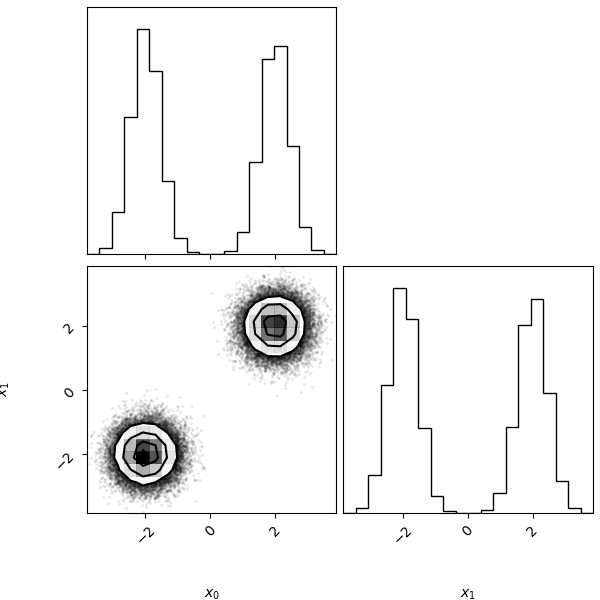

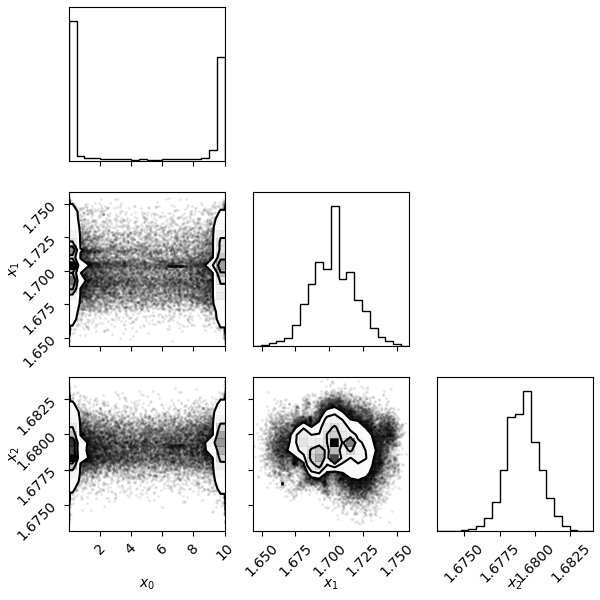

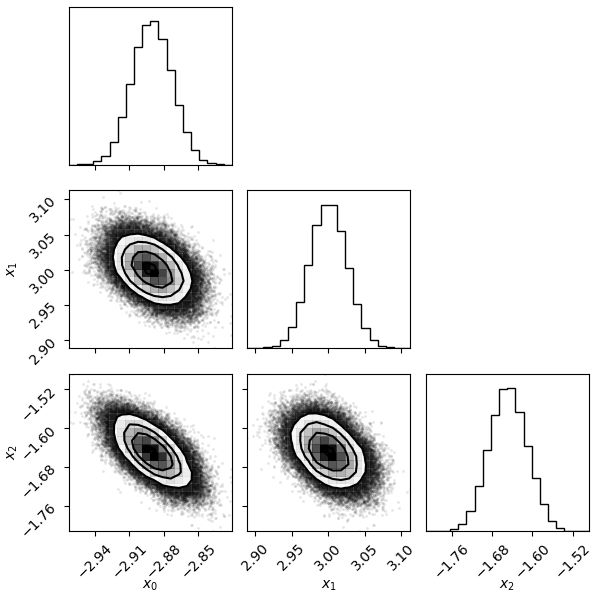

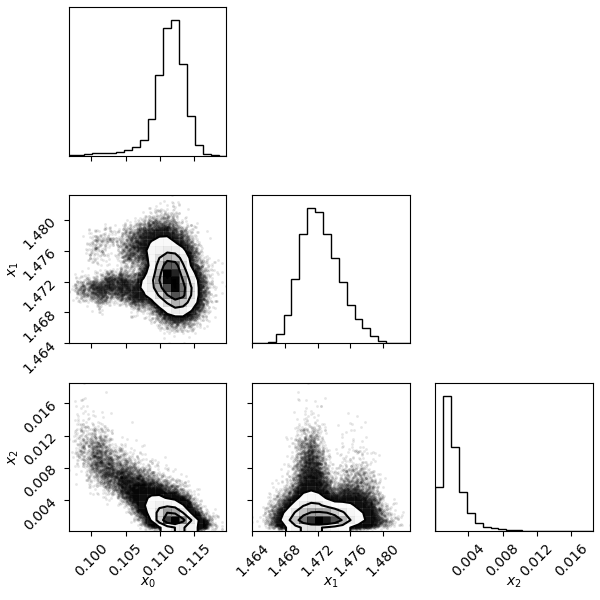

In [3]:
from pyvbmc import VariationalPosterior

doubly_peaked_vp = VariationalPosterior.load("doubly_peaked_vp.pkl")
D3_vp = VariationalPosterior.load('3D_vp.pkl')
better_d3_vp = VariationalPosterior.load('3d_vp_reasonable.pkl')
cool_vp = VariationalPosterior.load('wild_and_wacky_3d_vp.pkl')
new_vp = VariationalPosterior.load("3d_for_plotting_vp.pkl")


doubly_peaked_vp.plot()
D3_vp.plot()
better_d3_vp.plot()
cool_vp.plot()

true_a_b = [[-2.,-2.],[2.,2.]]
true_3d = [[np.pi/2, 2., 2.], [np.pi**2, 2., 2.]]
true_b_3d = [-2.89037176, 3., -1.64865863]
true_cool_3d = [1.,1.,1.]
true_new = [1.,1.,1.]

Now we again want to take the samples above the threshold. There are a few changes this time, which are explained in the code.

In [78]:
def samples_above_threshold(vp, true_value, n_samples, lower_thresh_const):

    hit  = False # to check if there are more than one true value
    true_value = np.asarray(true_value, float)
    try:
        true_value[0][0] 
    except:
        hit = True

    if hit:
        threshold = vp.pdf(true_value)
    else:
        threshold = min(vp.pdf(np.array(true_value))) # grabs the smallest pdf if there are more than one true value
        
    threshold_edited = threshold * lower_thresh_const
    Xs, _ = vp.sample(n_samples * 5) # get samples out of the distribution, do 5 times to make sure you hit the n_samples below
    pdfs = vp.pdf(Xs) # find the pdf of each of those samples  

    high_threshold_samples = []

    for i in range(len(pdfs)): # the while + for loop wasn't working so I just had it add samples up to n_samples and check when to break
        if pdfs[i] >= threshold_edited and len(high_threshold_samples) <= n_samples: 
            high_threshold_samples.append(Xs[i])
            if len(high_threshold_samples) == n_samples:
                break

    return np.array(high_threshold_samples)

The above code can be checked like this:

In [20]:
thresh_samp = samples_above_threshold(doubly_peaked_vp, true_a_b, int(5e5), .75)
thresh_samp_3D = samples_above_threshold(D3_vp, true_3d, int(5e5), .75)

/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/variational_posterior/variational_posterior.py:555: RuntimeWarning: overflow encountered in divide
  y[mask] /= np.exp(


We can then easily plot the 3d points as so (the graphs should be able to move if you drag them):

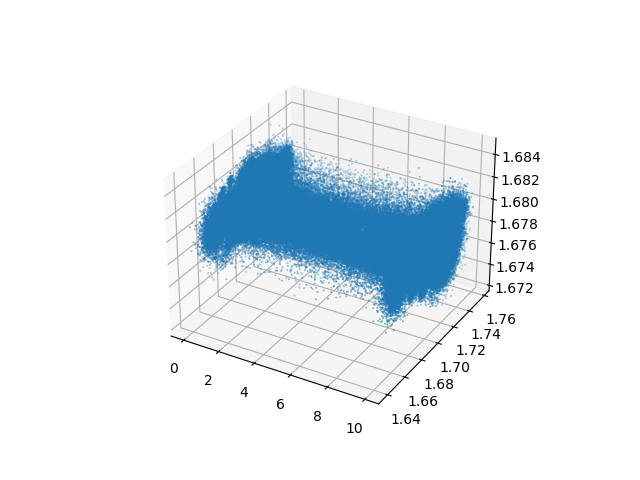

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
xs, ys, zs = thresh_samp_3D[:,0], thresh_samp_3D[:,1], thresh_samp_3D[:,2]
ax.scatter(xs, ys, zs, s=.1)

Now we begin building the cluster creator, don't worry about anything there, just follow the way I call it and it should work.

In [22]:
def minkowskiDist(v1, v2):
    #Assumes v1 and v2 are equal length arrays of numbers
    dist = 0
    for i in range(len(v1)):
        dist += abs(v1[i] - v2[i])**2
    return dist**(1/2)

In [24]:
class Example(object):
    
    def __init__(self, features):
        #Assumes features is an array of floats
        self.features = features

    def dimensionality(self):
        return len(self.features)

    def getFeatures(self):
        return self.features[:]
    
    def distance(self, other):
        return minkowskiDist(self.features, other.getFeatures())

In [25]:
class Cluster(object):
    
    def __init__(self, examples):
        """Assumes examples a non-empty list of Examples"""
        self.examples = examples
        self.centroid = self.computeCentroid()
        
    def update(self, examples):
        """Assume examples is a non-empty list of Examples
           Replace examples; return amount centroid has changed"""
        oldCentroid = self.centroid
        self.examples = examples
        self.centroid = self.computeCentroid()
        return oldCentroid.distance(self.centroid)
    
    def computeCentroid(self):
        vals = np.array([0.0]*self.examples[0].dimensionality())
        for e in self.examples: #compute mean
            vals += e.getFeatures()
        centroid = Example(vals/ len(self.examples))
        return centroid

    def getCentroid(self):
        return self.centroid

    def inertia(self):
        totDist = 0
        for e in self.examples:
            totDist += (e.distance(self.centroid))**2
        return totDist
        
    def members(self):
        for e in self.examples:
            yield e  

In [26]:
def kmeans(examples, k, verbose = False):
    #Get k randomly chosen initial centroids, create cluster for each
    initialCentroids = random.sample(examples, k)
    clusters = []
    for e in initialCentroids:
        clusters.append(Cluster([e]))
        
    #Iterate until centroids do not change
    converged = False
    numIterations = 0
    while not converged:
        numIterations += 1
        #Create a list containing k distinct empty lists
        newClusters = []
        for i in range(k):
            newClusters.append([])
            
        #Associate each example with closest centroid
        for e in examples:
            #Find the centroid closest to e
            smallestDistance = e.distance(clusters[0].getCentroid())
            index = 0
            for i in range(1, k):
                distance = e.distance(clusters[i].getCentroid())
                if distance < smallestDistance:
                    smallestDistance = distance
                    index = i
            #Add e to the list of examples for appropriate cluster
            newClusters[index].append(e)

        for c in newClusters: #Avoid having empty clusters
            if len(c) == 0:
                raise ValueError('Empty Cluster')
        
        #Update each cluster; check if a centroid has changed
        converged = True
        for i in range(k):
            if clusters[i].update(newClusters[i]) > 0.0:
                converged = False
        #plotClusters(clusters)
        if verbose:
            print('Iteration #' + str(numIterations))
            for c in clusters:
                print(c)
            print('') #add blank line

    return clusters

In [27]:
def totalInertia(clusters):
    """Assumes clusters a list of clusters
       Returns a measure of the total dissimilarity of the
       clusters in the list"""
    totDist = 0
    for c in clusters:
        totDist += c.inertia()
    return totDist

In [28]:
def trykmeans(examples, numClusters, numTrials, verbose = False):
    """Calls kmeans numTrials times and returns the result with the
          lowest dissimilarity"""
    best = kmeans(examples, numClusters, verbose)
    trial = 1
    while trial < numTrials:
        try:
            clusters = kmeans(examples, numClusters, verbose)
        except ValueError:
            continue #If failed, try again
        if totalInertia(clusters) < totalInertia(best):
            best = clusters
        trial += 1
    return best

In [29]:
def getData2Features(pts): # 2-D version NOT USED ANYMORE
    #read in data
    points = []
    for i in range(len(pts)):
        points.append(Example(np.array([pts[i][0],pts[i][1]])))
    return points

In [32]:
def getDataFeatures(pts): #n-dimensional version
    points = []
    dim = len(pts[0])

    for i in range(len(pts)):
        point = []
        for j in range(dim):
            point.append(pts[i][j])
        points.append(Example(np.array(point)))
        
    return points

Let's double check it works (does not graph it, we're just looking for it to run without errors):

In [33]:
thresh_samp_3d = samples_above_threshold(doubly_peaked_vp, true_a_b, int(5e5), .75)
try1_3d = getDataFeatures(thresh_samp_3d)
try_k_3d = trykmeans(try1_3d, 2, 5)

The cluster stuff kinda comes out weird, so we need to actually make it a list of lists so the rest of the stuff can read it:

In [34]:
def get_cluster_points(try_kmeans):
    try_k = try_kmeans
    all_clusters = []
    for cluster in try_k:
        cluster_pts = []
        examples_cluster = cluster.examples
        for examp in examples_cluster:
            cluster_pts.append(examp.getFeatures())
        all_clusters.append(np.array(cluster_pts))
    return all_clusters

Again check for any issues:

In [37]:
th_samp_3d = samples_above_threshold(D3_vp, true_3d, int(2e3), .75)
try2_3d = getDataFeatures(th_samp_3d)
try2_k_3d = trykmeans(try2_3d, 1, 5)
clust = get_cluster_points(try2_k_3d)

/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/variational_posterior/variational_posterior.py:555: RuntimeWarning: overflow encountered in divide
  y[mask] /= np.exp(


Below is commented out for a reason, but if you wanna check your clusters, this will do it in 2d, just make sure to make the correct amount of colors you want.

In [36]:
# # colors = ['b','g','r','c','m','y','k','orange','purple','brown','pink','gray']
# colors = ['b','g']

# for i in range(len(cluster_all)):
#     # plt.scatter(cluster_all[i][:,0], cluster_all[i][:,1], color=colors[i], s=.1)
#     plt.scatter(cluster_all[i][:,0], cluster_all[i][:,1], color='b', s=.1)
#     tri = Delaunay(cluster_all[i])
#     # plt.triplot(cluster_all[i][:,0], cluster_all[i][:,1], tri.simplices, color= colors[-i], lw=.1)
#     plt.triplot(cluster_all[i][:,0], cluster_all[i][:,1], tri.simplices, color= 'g', lw=.1)

# # plt.xlim(.48,.485)
# # plt.ylim(1.465, 1.48)

Below is my attempt to plot out like the acutal tetrahedrons, it works but its very weird so there's that. There are MUCH better graphs below

In [38]:
import plotly.graph_objects as go

pts = clust[0]

x, y, z = pts.T

tri = Delaunay(clust[0])
indices = tri.simplices

vertices = clust[0][indices]

d = indices[:,0]
e = indices[:,1]
f = indices[:,2]

i_ = []
j_ = []
k_ = []
colors = []

for l in range(len(indices[:,0])):
    colors.append(((l+ 50)%255, l%255, (l+100)%255))

fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=d, j=e, k=f,
                   opacity=0.4, vertexcolor = colors)])

fig.show()

Okay now is the actual good plots.

In [124]:
def plot_tri_2(ax, points, tri):
    edges = collect_edges(tri)
    x = np.array([])
    y = np.array([])
    z = np.array([])
    red = "#C41230"
    grey = "#E0E0E0"
    plt.style.use("ggplot")
    for (i,j) in edges:
        x = np.append(x, [points[i, 0], points[j, 0], np.nan])      
        y = np.append(y, [points[i, 1], points[j, 1], np.nan])      
        z = np.append(z, [points[i, 2], points[j, 2], np.nan])
    
    ax.plot3D(x, y, z, color='red', lw='0.1')
    # ax.scatter(points[:,0], points[:,1], points[:,2], color='grey', s=1)

def collect_edges(tri):
    edges = set()

    def sorted_tuple(a,b):
        return (a,b) if a < b else (b,a)
    # Add edges of tetrahedron (sorted so we don't add an edge twice, even if it comes in reverse order).
    for (i0, i1, i2, i3) in tri.simplices:
        edges.add(sorted_tuple(i0,i1))
        edges.add(sorted_tuple(i0,i2))
        edges.add(sorted_tuple(i0,i3))
        edges.add(sorted_tuple(i1,i2))
        edges.add(sorted_tuple(i1,i3))
        edges.add(sorted_tuple(i2,i3))
    return edges

In [120]:

# we'll use ggplot style for now
# plt.style.use("ggplot")
# # use red first, then blue then green for single plots
# red = "#C41230"
# blue  = "#007BC0"
# green = "#009647"
# # linewidth 2 like this:
#plt.plot(x,y,c = red, lw = 2)

In [123]:
def plot_del_3d(vp, true_value, n_samples, lower_thresh_const): # KEEP THE n_samples TO LIKE int(2e3) -> still works for more, just takes longer to run
    samp = samples_above_threshold(vp, true_value, n_samples, lower_thresh_const)
    make_data_features = getDataFeatures(samp)
    get_k_means = trykmeans(make_data_features, 1, 5)
    clust = get_cluster_points(get_k_means)
    fig = plt.figure(figsize=(10,10))
    fig.patch.set_facecolor('white')
    ax = plt.axes(projection='3d')
    for i in range(len(clust)):
        tri = Delaunay(clust[i])
        plot_tri_2(ax,clust[i],tri)

/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/variational_posterior/variational_posterior.py:555: RuntimeWarning:

overflow encountered in divide



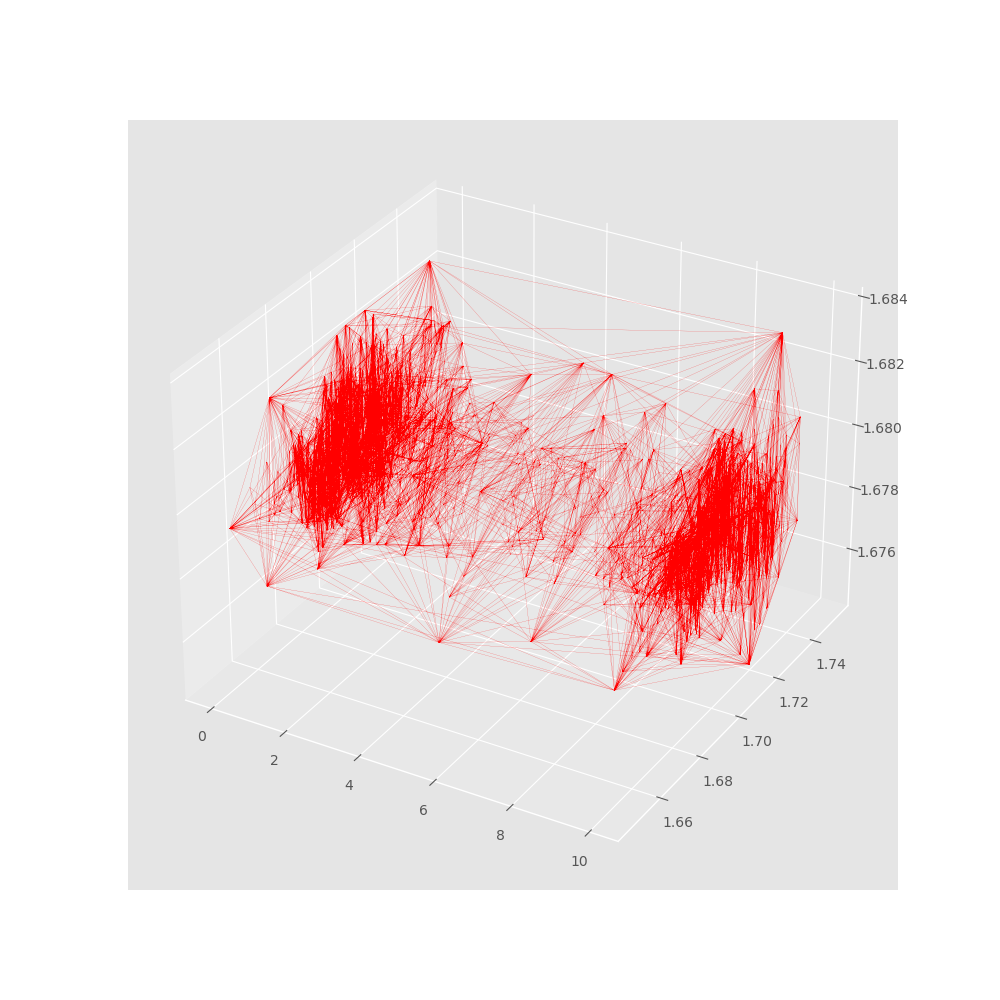

In [110]:
plot_del_3d(D3_vp, true_3d, int(2e3), .75)

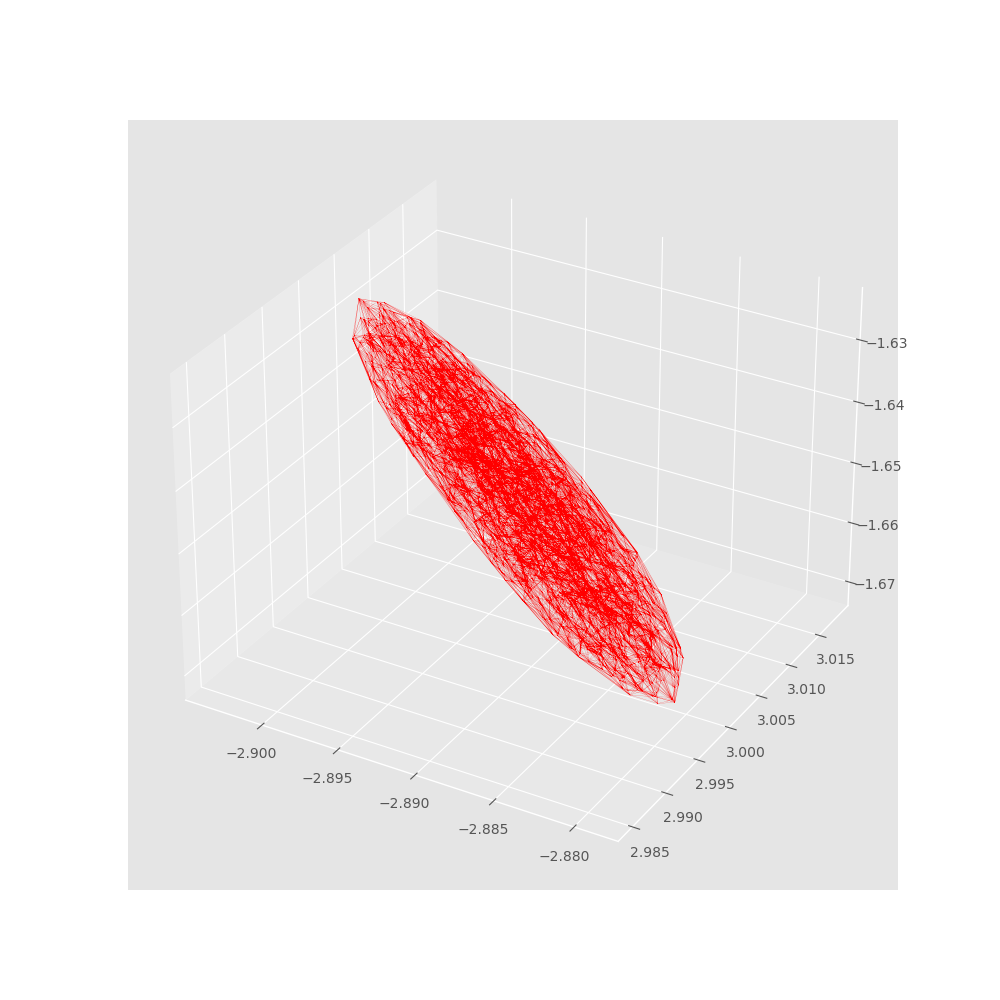

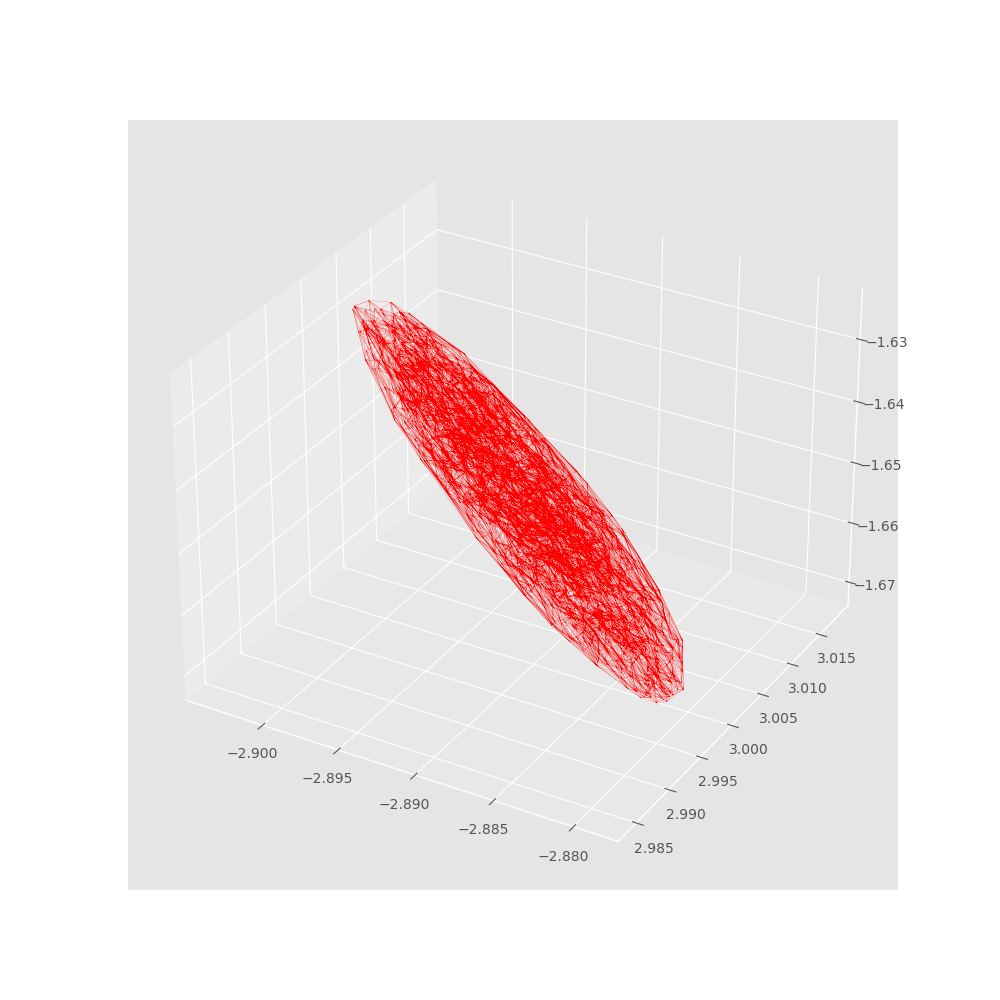

In [125]:
plot_del_3d(better_d3_vp, true_b_3d, int(7e3), .75)
plot_del_3d(better_d3_vp, true_b_3d, int(7e3), .75)

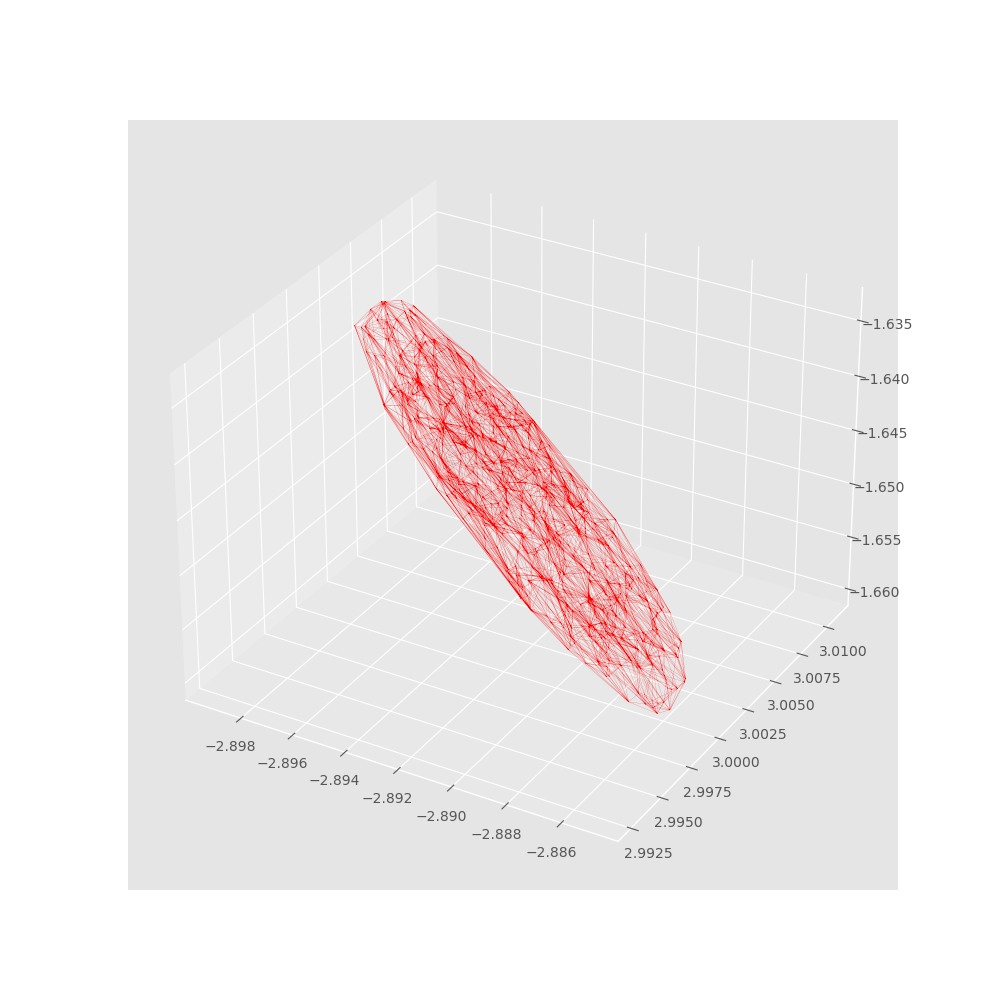

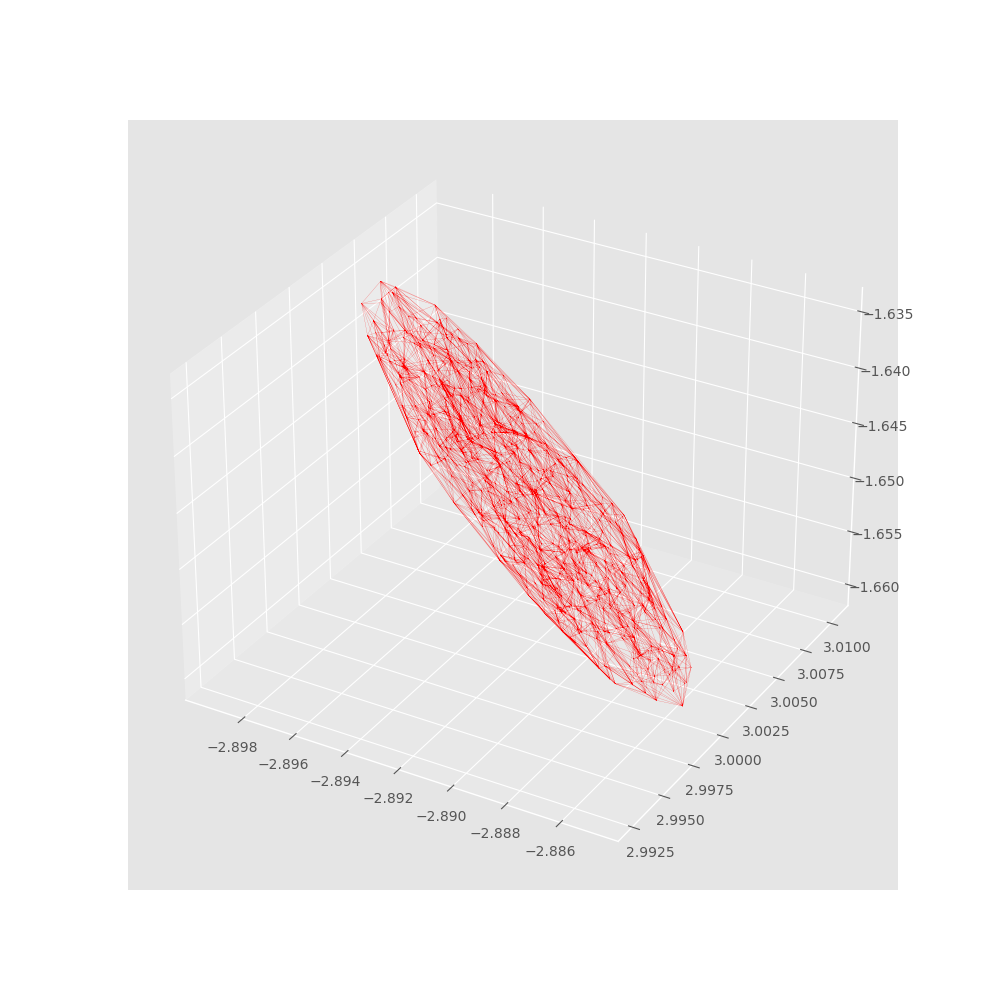

In [115]:
plot_del_3d(better_d3_vp, true_b_3d, int(7e3), .9)
plot_del_3d(better_d3_vp, true_b_3d, int(7e3), .9)

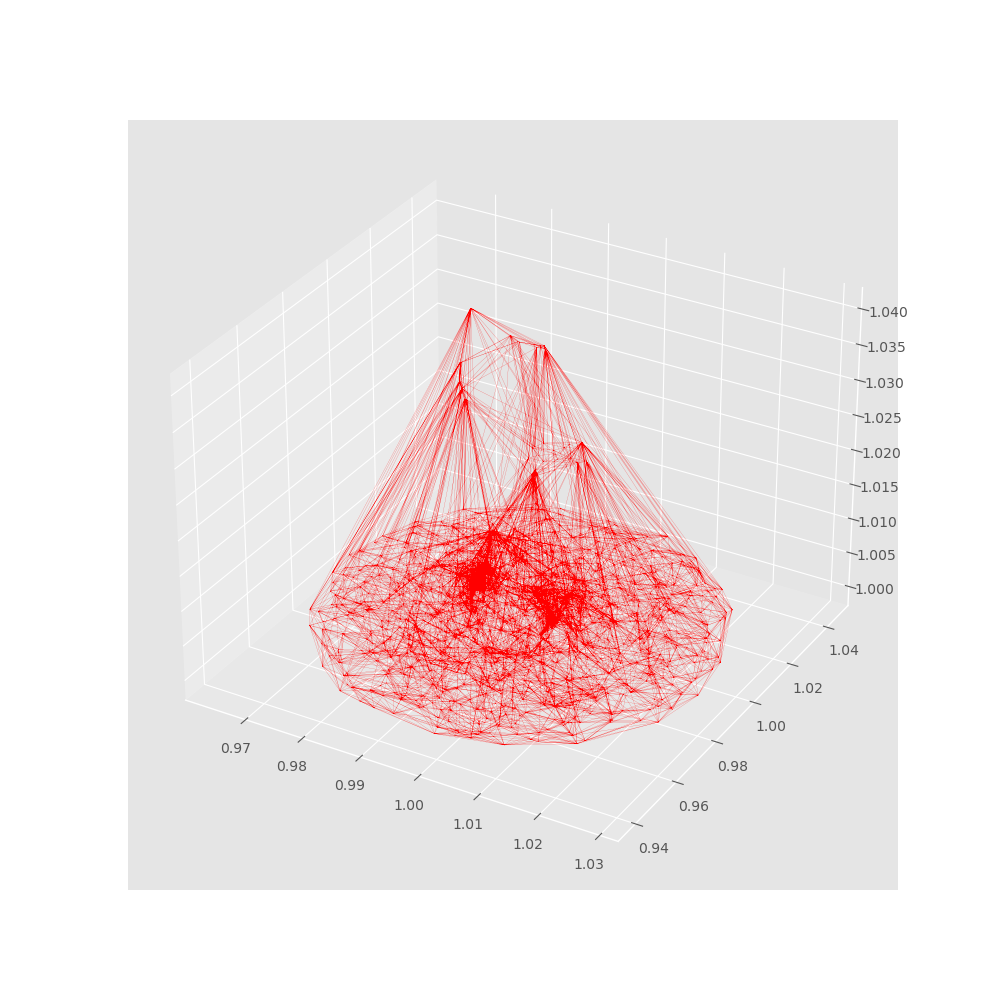

In [112]:
plot_del_3d(new_vp, true_cool_3d, int(2e3), .75)

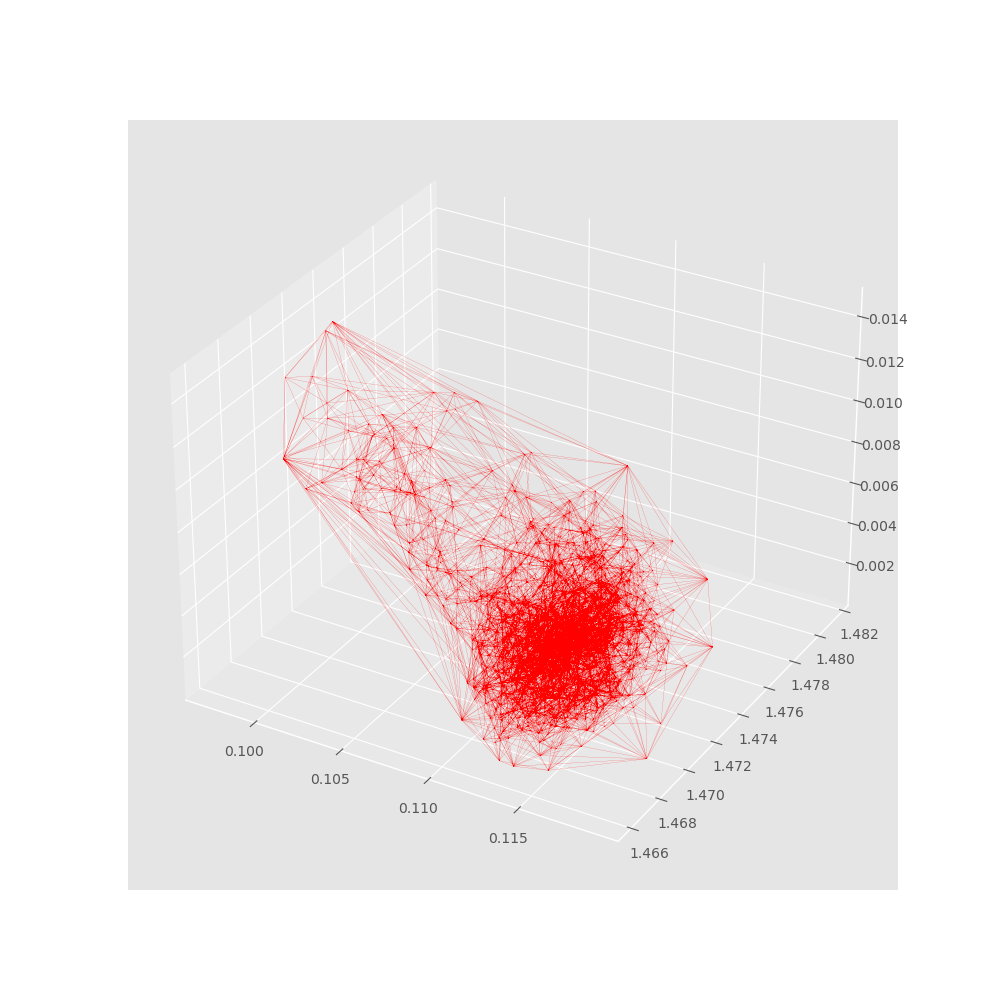

In [118]:
plot_del_3d(cool_vp, true_cool_3d, int(2e3), 1.)

# we'll use ggplot style for now
# plt.style.use("ggplot")
# use red first, then blue then green for single plots
# red = "#C41230"
# blue  = "#007BC0"
# green = "#009647"
# linewidth 2 like this:
# plt.plot(x,y,c = red, lw = 2)

Now we want to actually know the Delaunay triangles, not plot them:

In [46]:
def get_Delaunay(vp, clusters): # this works for 2-D NOT USED ANYMORE

    integrals = 0
    for i in range(len(clusters)):
        tri = Delaunay(clusters[i])
        indices = tri.simplices
        vertices = clusters[i][indices]
        areas = []
        centroids = []

        for pnt in vertices:
            Ax, Ay, Bx, By, Cx, Cy = pnt[0][0], pnt[0][1], pnt[1][0], pnt[1][1], pnt[2][0], pnt[2][1]
            areas.append(abs(Ax*(By-Cy) + Bx*(Cy-Ay) + Cx*(Ay-By)))
            centroids.append([(Ax+Bx+Cx)/2, (Ay+By+Cy)/2])

        pdfs = vp.pdf(centroids)
        integral = np.array(areas) @ pdfs
        integrals += integral
    
    return integrals
    

Below gives us the centroid and volume of an n-dimensional simplex, it gets called a lot in the function (should prob make faster).

In [48]:
def deter(pnts):
    v0 = np.array(pnts[0])
    n = len(pnts) - 1
    arry = []
    centroid = []

    for i in range(n + 1):
        if i != n:
            centroid.append(sum(pnts[:,i]) / (n+1)) # just gets all the x values and averages them, then y values, etc
        if i == 0:
            continue
        arry.append(np.array(pnts[i]) - v0) # making an matrix of vectors from one vertex to another (all to v0)

    arry_ = np.array(arry)
    det = abs(np.linalg.det(arry_))
    vol = det/np.math.factorial(n)

    return vol, centroid

Now we want the actual integral. This checks if there are clusters or not (has to do each one separately).

In [69]:
def get_Delaunay_integral_n(vp, clusters, num_clusts):

    integrals = 0
    if num_clusts == 0:
        tri = Delaunay(clusters)
        indices = tri.simplices
        vertices = clusters[indices]
        
        vols = []
        centroids = []
        for pnts in vertices:
            # print(pnts)
            det = deter(pnts)
            vols.append(det[0])
            centroids.append(det[1])
        
        pdfs = vp.pdf(np.array(centroids)) # pdf of the centroids
        integrals = np.array(vols) @ pdfs # just the dot product

    else:
        for i in range(len(clusters)):
            tri = Delaunay(clusters[i])
            indices = tri.simplices
            vertices = clusters[i][indices]
            
            vols = []
            centroids = []
            for pnts in vertices:
                det = deter(pnts)
                vols.append(det[0])
                centroids.append(det[1])
            
            pdfs = vp.pdf(np.array(centroids))
            integral = np.array(vols) @ pdfs

            integrals += integral
    
    return integrals

Next we put it all together:

In [59]:
def Del_integral_n_dim(vp, true_value, n_samples, num_clusts, lower_thresh_const):
    samp = samples_above_threshold(vp, true_value, n_samples, lower_thresh_const)
    if num_clusts == 0:
        integral = get_Delaunay_integral_n(vp, samp, num_clusts)
    else:
        make_data_features = getDataFeatures(samp)
        get_k_means = trykmeans(make_data_features, num_clusts, 5)
        clust = get_cluster_points(get_k_means)
        integral = get_Delaunay_integral_n(vp, clust, num_clusts)
    return integral

Now, we check to make sure it works!

In [60]:
Del_integral_n_dim(doubly_peaked_vp, true_a_b, int(5e5), num_clusts=2, lower_thresh_const=.75)

array([0.28388595])

In [70]:
Del_integral_n_dim(better_d3_vp, true_b_3d, int(5e5), 0, .75)

array([0.074876])

In [116]:
Del_integral_n_dim(better_d3_vp, true_b_3d, int(5e5), 0, .9)

array([0.01732081])

In [63]:
Del_integral_n_dim(cool_vp, true_cool_3d, int(5e5), 0, .75)

array([0.99892955])

In [119]:
Del_integral_n_dim(cool_vp, true_cool_3d, int(5e5), 0, 1.)

array([0.9989164])